In [1]:
import torch
import copy
import numpy as np 
import pandas as pd 
import seaborn as sns 
from pylab import rcParams
import matplotlib.pyplot as plt 
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim
import torch.nn.functional as F
from arff2pandas import a2p

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
# Assign the torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DATA IMPORT

In [87]:
# Load data from arff file
with open('./ECG5000/ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)

with open('./ECG5000/ECG5000_TEST.arff') as f:
    test = a2p.load(f)

In [145]:
# Concatenate train and test data to provide larger base for learning
ecg_df = train.append(test)

#Shuffle the data rows to avoid patterns
ecg_df = ecg_df.sample(frac=1.0)    

In [156]:
CLASS_NORMAL = 'Normal'

In [157]:
# Rename the final column in the ECG data to make more sense
new_columns = list(ecg_df.columns)
new_columns[-1] = 'Heartbeat Classes'
ecg_df.columns = new_columns

ecg_df['Heartbeat Classes'].replace({'1':'Normal', '2':'R on T', '3':'PVC', '4':'SP or EB', '5':'UB'}, inplace=True)

## EXPLORATION

In [158]:
# Count the spread of HB classes
ecg_df['Heartbeat Classes'].value_counts()

Normal      2919
R on T      1767
SP or EB     194
PVC           96
UB            24
Name: Heartbeat Classes, dtype: int64

[Text(0.5, 0, 'HEARTBEAT CLASSES'), Text(0, 0.5, 'COUNT')]

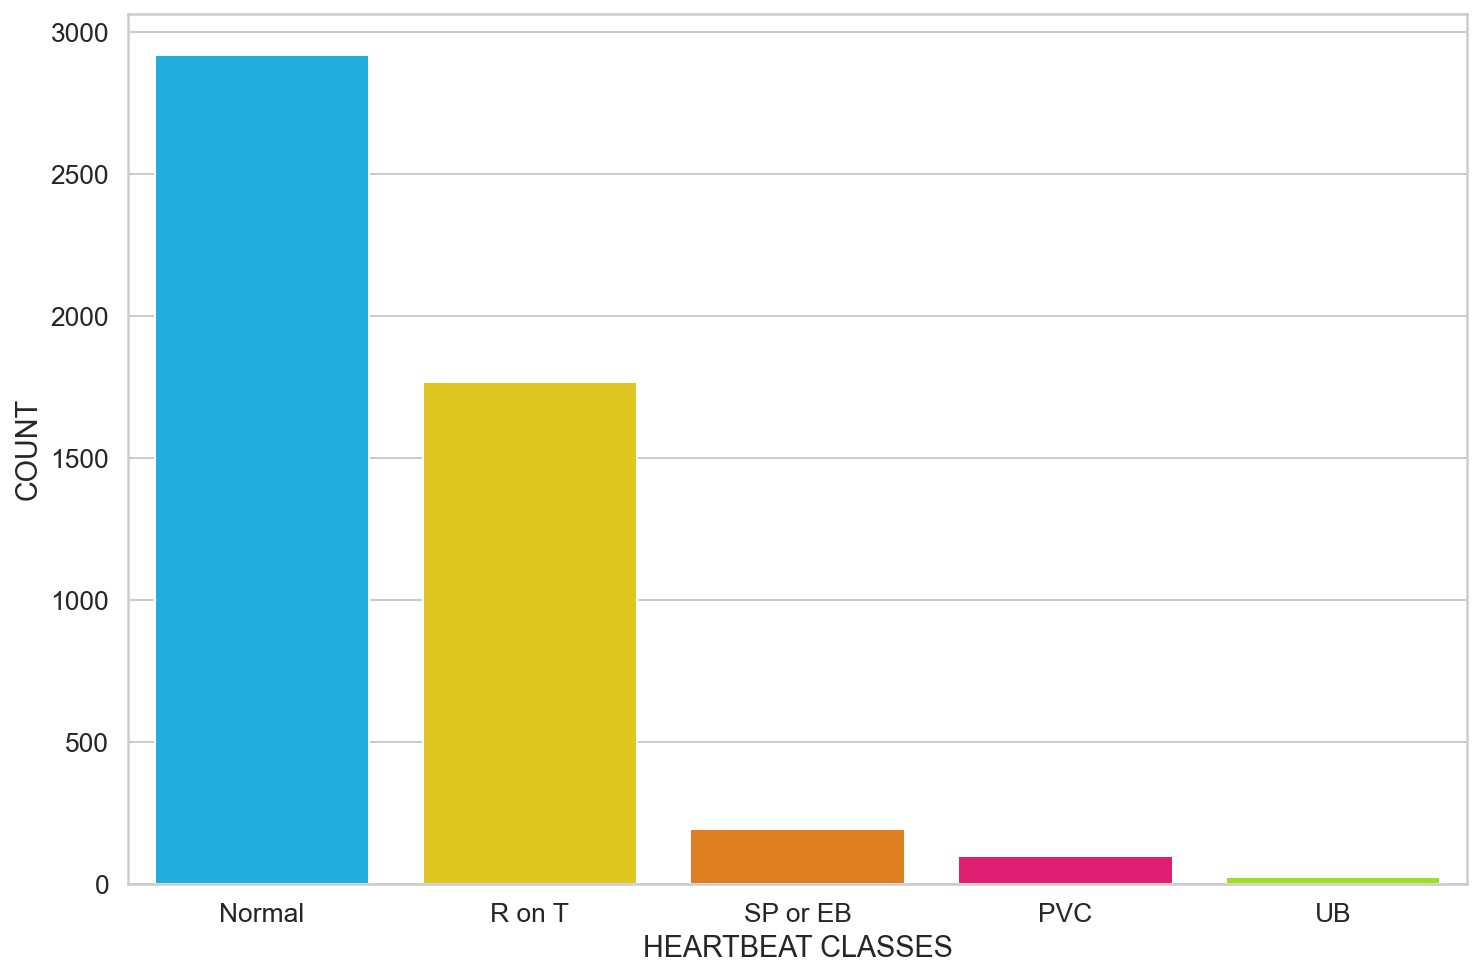

In [214]:
# Visualize the spread of these classes
ax = sns.countplot(ecg_df['Heartbeat Classes'])
ax.set(xlabel='HEARTBEAT CLASSES', ylabel='COUNT')

In [160]:
# Function to convert to and plot time series data, rolling average with standard deviations
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)

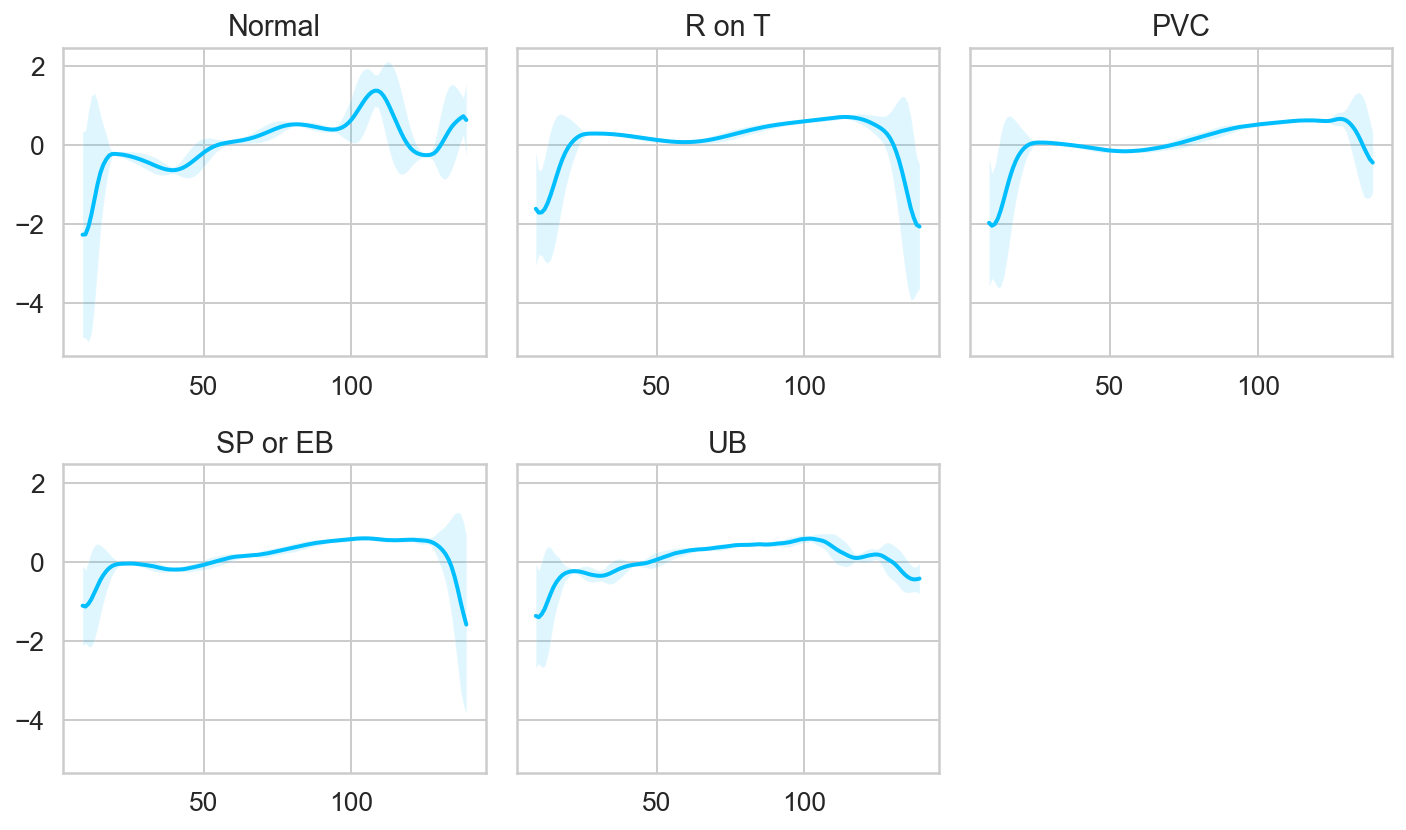

In [161]:
classes = ecg_df['Heartbeat Classes'].unique()

# Setup suplots and figure
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(10, 6)
    )

# Retrieve individual data for each class and use the plotting function from before
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = ecg_df[ecg_df['Heartbeat Classes'] == cls] \
        .drop(labels='Heartbeat Classes', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()

## DATA SPLITTING

In [196]:
# Retrieve all the normal ECG recordings
normal_df = ecg_df[ecg_df['Heartbeat Classes'] == CLASS_NORMAL].drop(labels='Heartbeat Classes', axis=1)

# Retrieve all the abnormal ECG recordings (any of the other 4 classes)
anomaly_df = ecg_df[ecg_df['Heartbeat Classes'] != CLASS_NORMAL].drop(labels='Heartbeat Classes', axis=1)

In [197]:
# Split normal data into 85% training and 15% validation data
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)

In [198]:
# Furthur split the validation data into 50% validation and 50% test data
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=RANDOM_SEED)

In [199]:
# Convert all data frames into sequences
train_sequences = train_df.astype(np.float32).to_numpy().tolist()
val_sequences = val_df.astype(np.float32).to_numpy().tolist()
test_sequences = test_df.astype(np.float32).to_numpy().tolist()
anomaly_sequences = anomaly_df.astype(np.float32).to_numpy().tolist()

In [200]:
# Function to convert sequences into torch tensors
def create_dataset(sequences):
    dataset = [torch.tensor(s).unsqueeze(1) for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

In [201]:
# Convert sequences into torch tensors
train_dataset, seq_len, n_features = create_dataset(train_sequences)

val_dataset, _, _ = create_dataset(val_sequences)
test_normal_dataset, _, _ = create_dataset(test_sequences)
test_anomaly_dataset, _, _ = create_dataset(anomaly_sequences)

## BUILD AN LSTM AUTOENCODER
Source - https://github.com/shobrook/sequitur <br>
Slightly tweeked autoencoder from existing repository above

The general Autoencoder architecture consists of two components. An Encoder that compresses the input and a Decoder that tries to reconstruct it.

In [202]:
# Encoder 
# The Encoder uses two LSTM layers to compress the Time Series data input.
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    # Layer 1
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    # Layer 2
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [203]:
# Decoder
# Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.
class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    # Layer 1
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    # Layer 2
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)

    x = x.reshape((self.seq_len, self.hidden_dim))
    return self.output_layer(x)

In [204]:
# Final LSTM Autoencoder module
# Our Autoencoder passes the input through the Encoder and Decoder.
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
    
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [205]:
# Create an instance of the autoencoder module
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim=128)
model = model.to(device)

## TRAINING THE MODEL

In [208]:
import time

# Define a function for training
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    start = time.time()
    model = model.train()
    
    train_losses = []
    
    for seq_true in train_dataset:
      optimizer.zero_grad()
      
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      
      loss = criterion(seq_pred, seq_true)
      
      loss.backward()
      optimizer.step()
      
      train_losses.append(loss.item())
    
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        
        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f'| EPOCH: {epoch} | TRAIN LOSS: {train_loss:.2f} | VAL LOSS: {val_loss:.2f} | EXEC. TIME: {((time.time() - start)/60):.2f} min |')
  
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [209]:
model, history = train_model(
    model, 
    train_dataset,
    val_dataset,
    n_epochs=50
)

KeyboardInterrupt: 

In [210]:
# Load trained model
model = torch.load('model.pth') 
model = model.to(device)

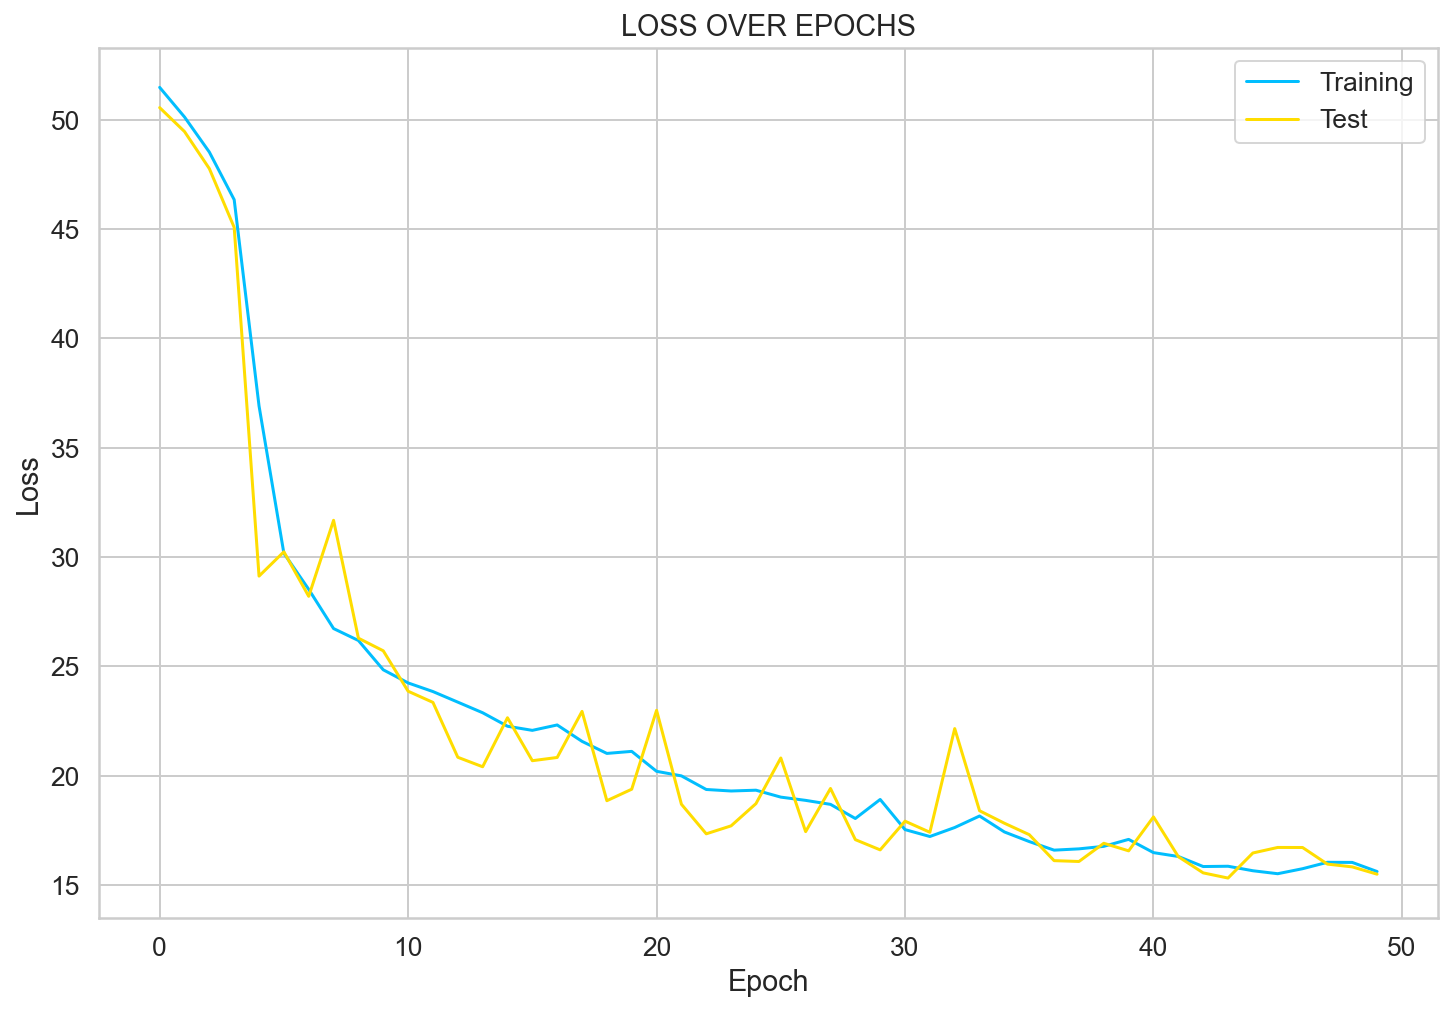

In [207]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'])
plt.title('LOSS OVER EPOCHS')
plt.show();

In [34]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [193]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

[Text(0.5, 0, 'LOSS'), Text(0, 0.5, 'DENSITY')]

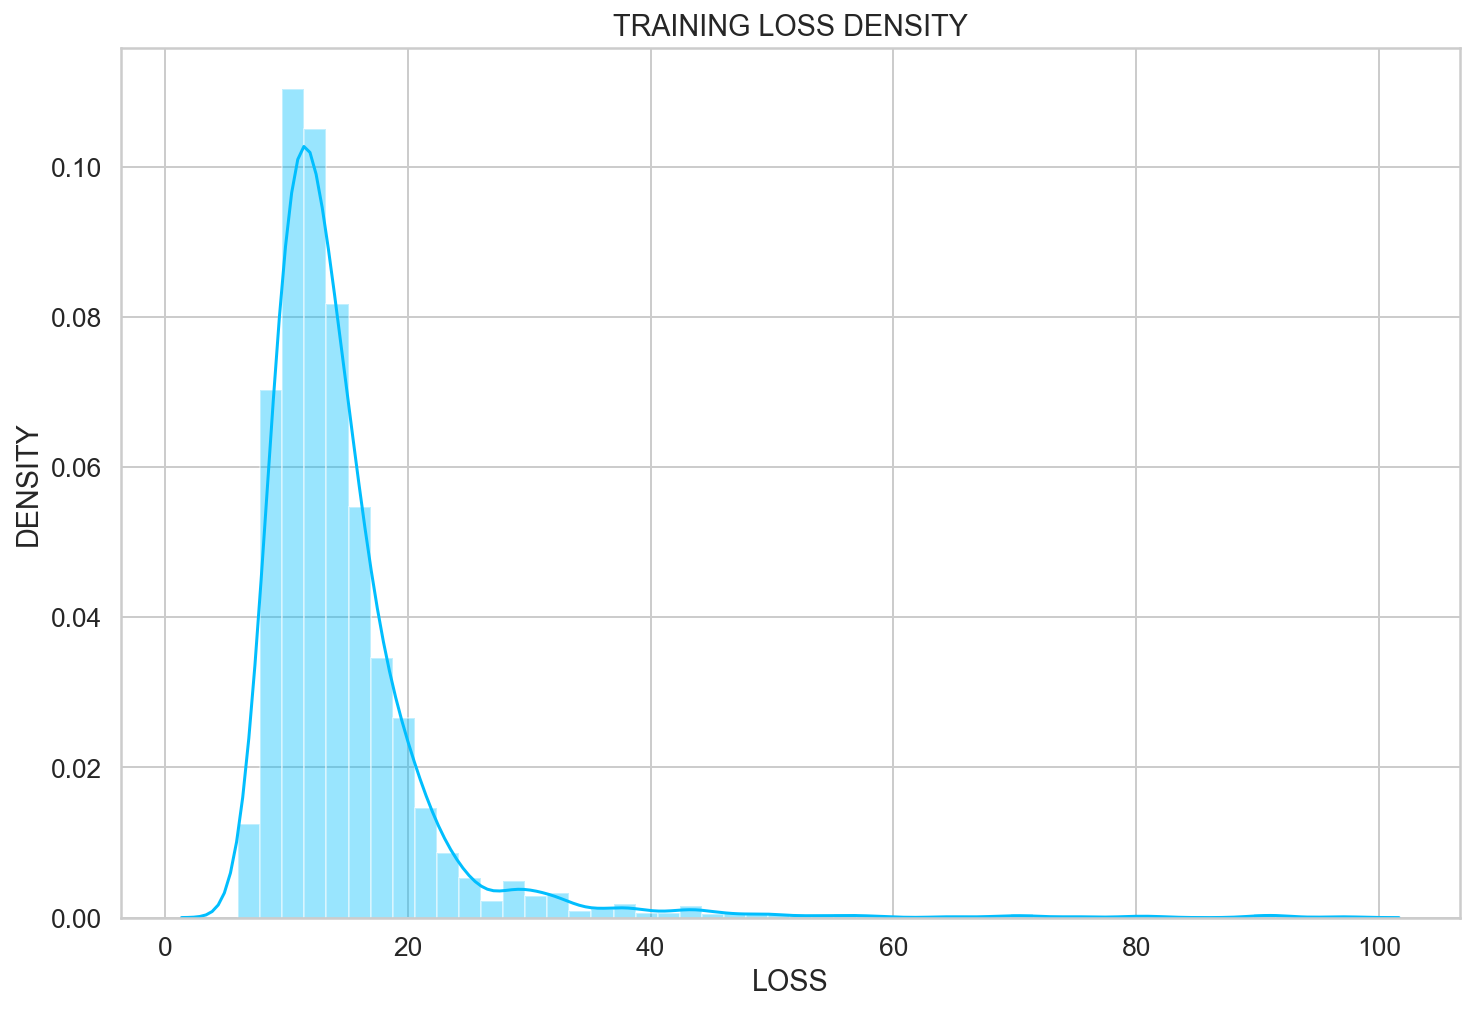

In [215]:
_, losses = predict(model, train_dataset)

ax = sns.distplot(losses, bins=50, kde=True)
ax.set_title('TRAINING LOSS DENSITY')
ax.set(xlabel='LOSS', ylabel='DENSITY')

In [37]:
THRESHOLD = 26

[Text(0.5, 0, 'LOSS'), Text(0, 0.5, 'DENSITY')]

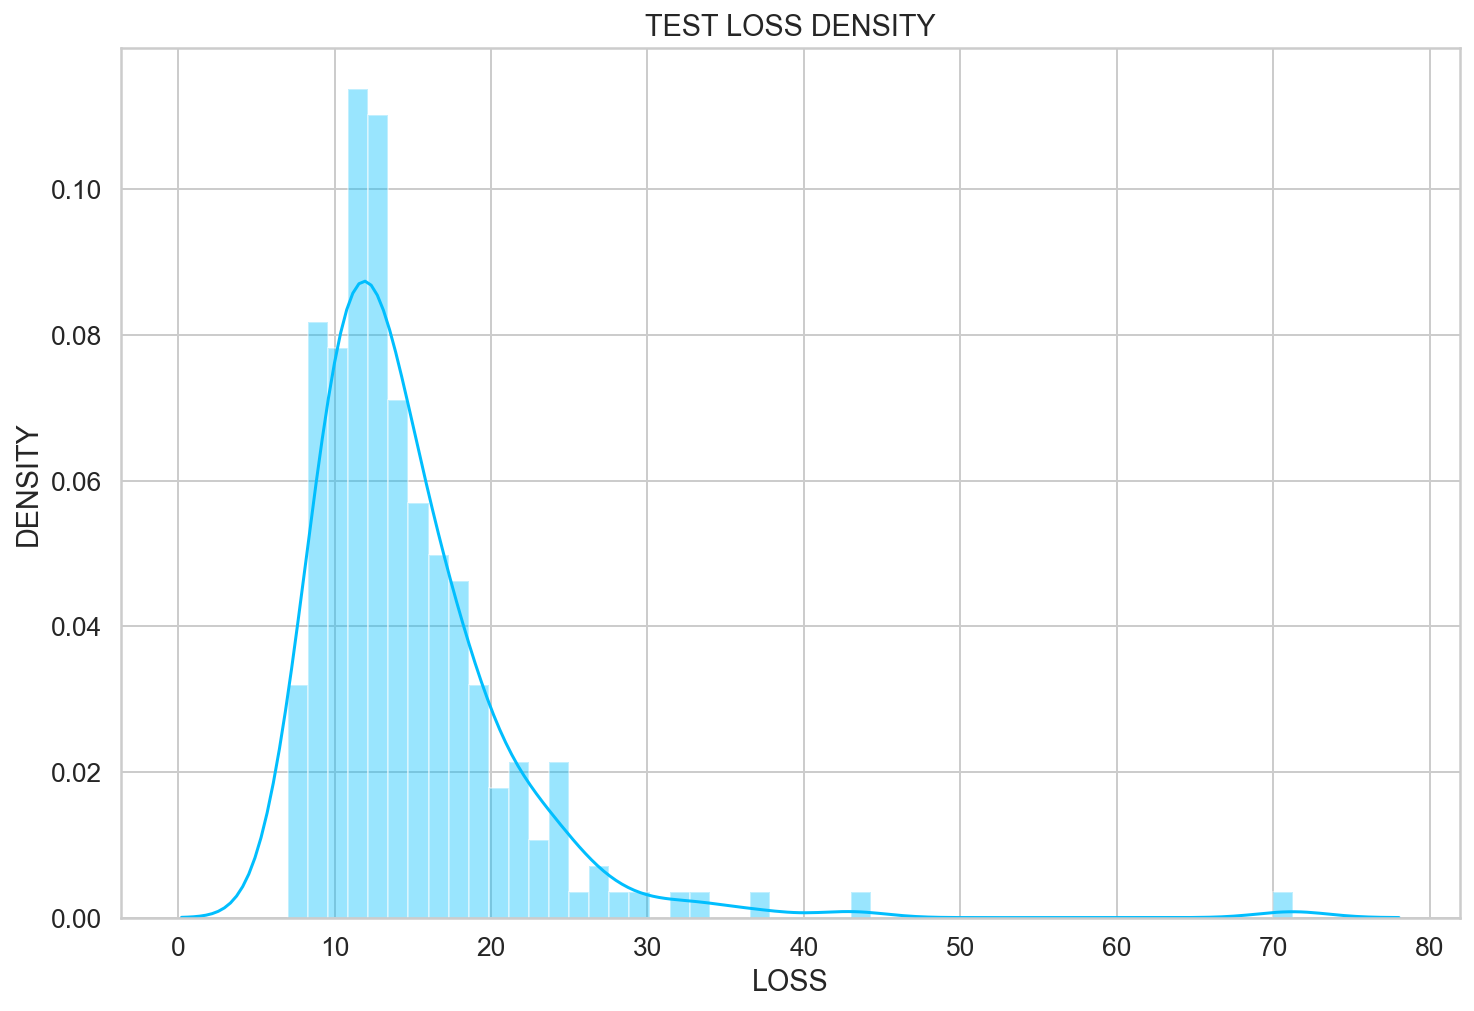

In [217]:
predictions, pred_losses = predict(model, test_normal_dataset)
ax = sns.distplot(pred_losses, bins=50, kde=True)
ax.set_title('TEST LOSS DENSITY')
ax.set(xlabel='LOSS', ylabel='DENSITY')

In [39]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 209/219


[Text(0.5, 0, 'LOSS'), Text(0, 0.5, 'DENSITY')]

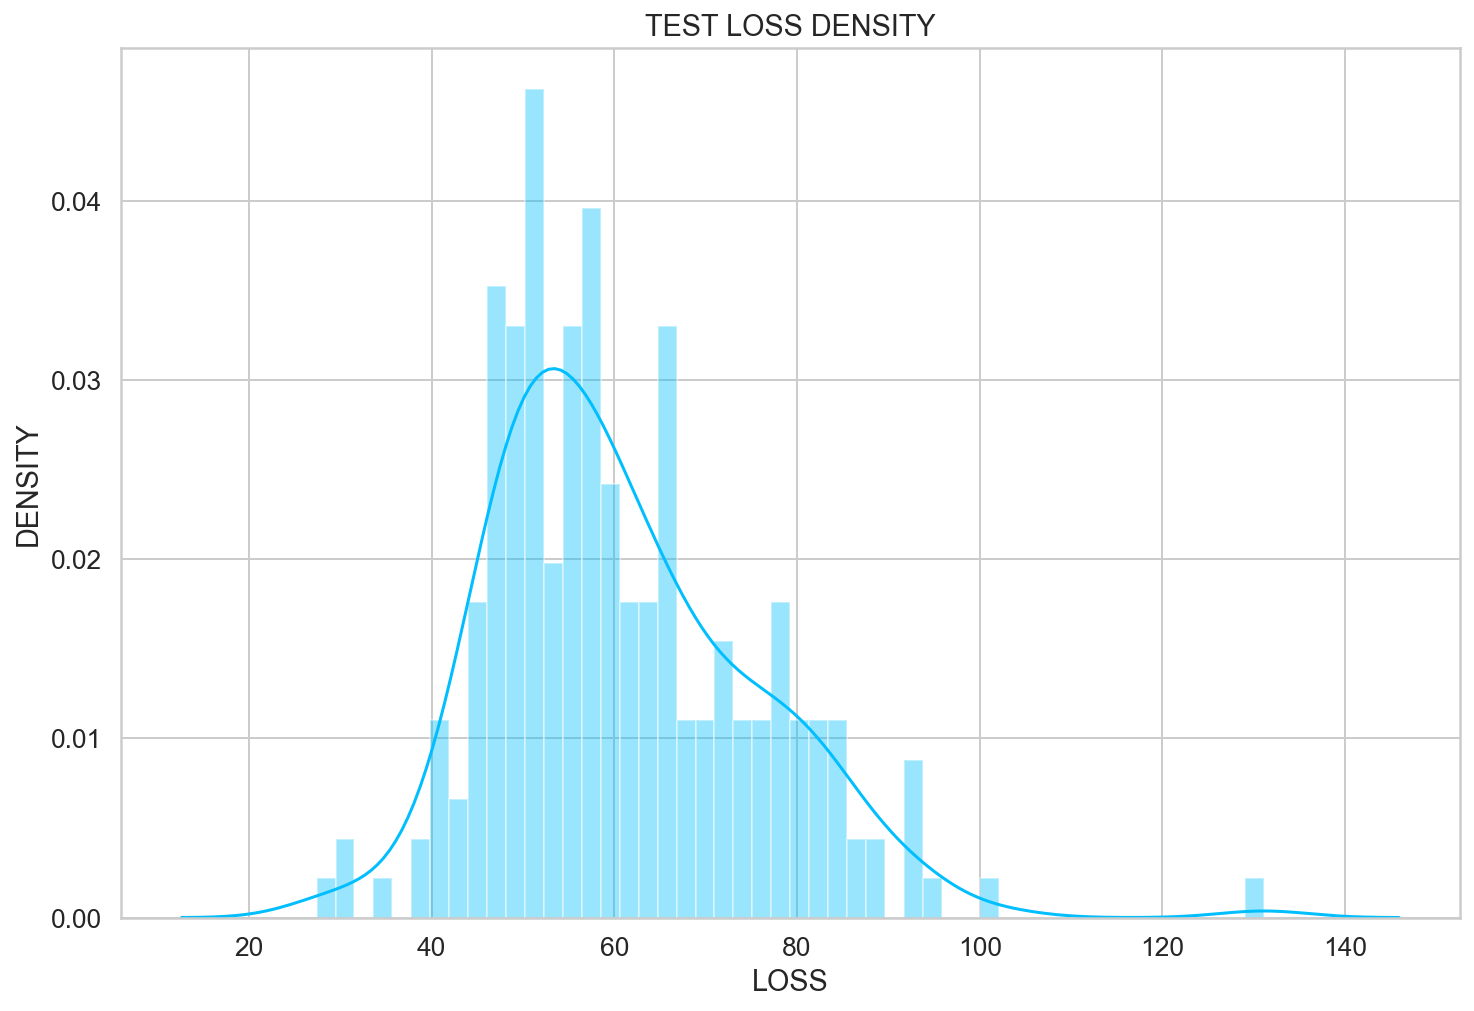

In [218]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict(model, anomaly_dataset)
ax = sns.distplot(pred_losses, bins=50, kde=True);
ax.set_title('TEST LOSS DENSITY')
ax.set(xlabel='LOSS', ylabel='DENSITY')

In [41]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 218/219


In [42]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

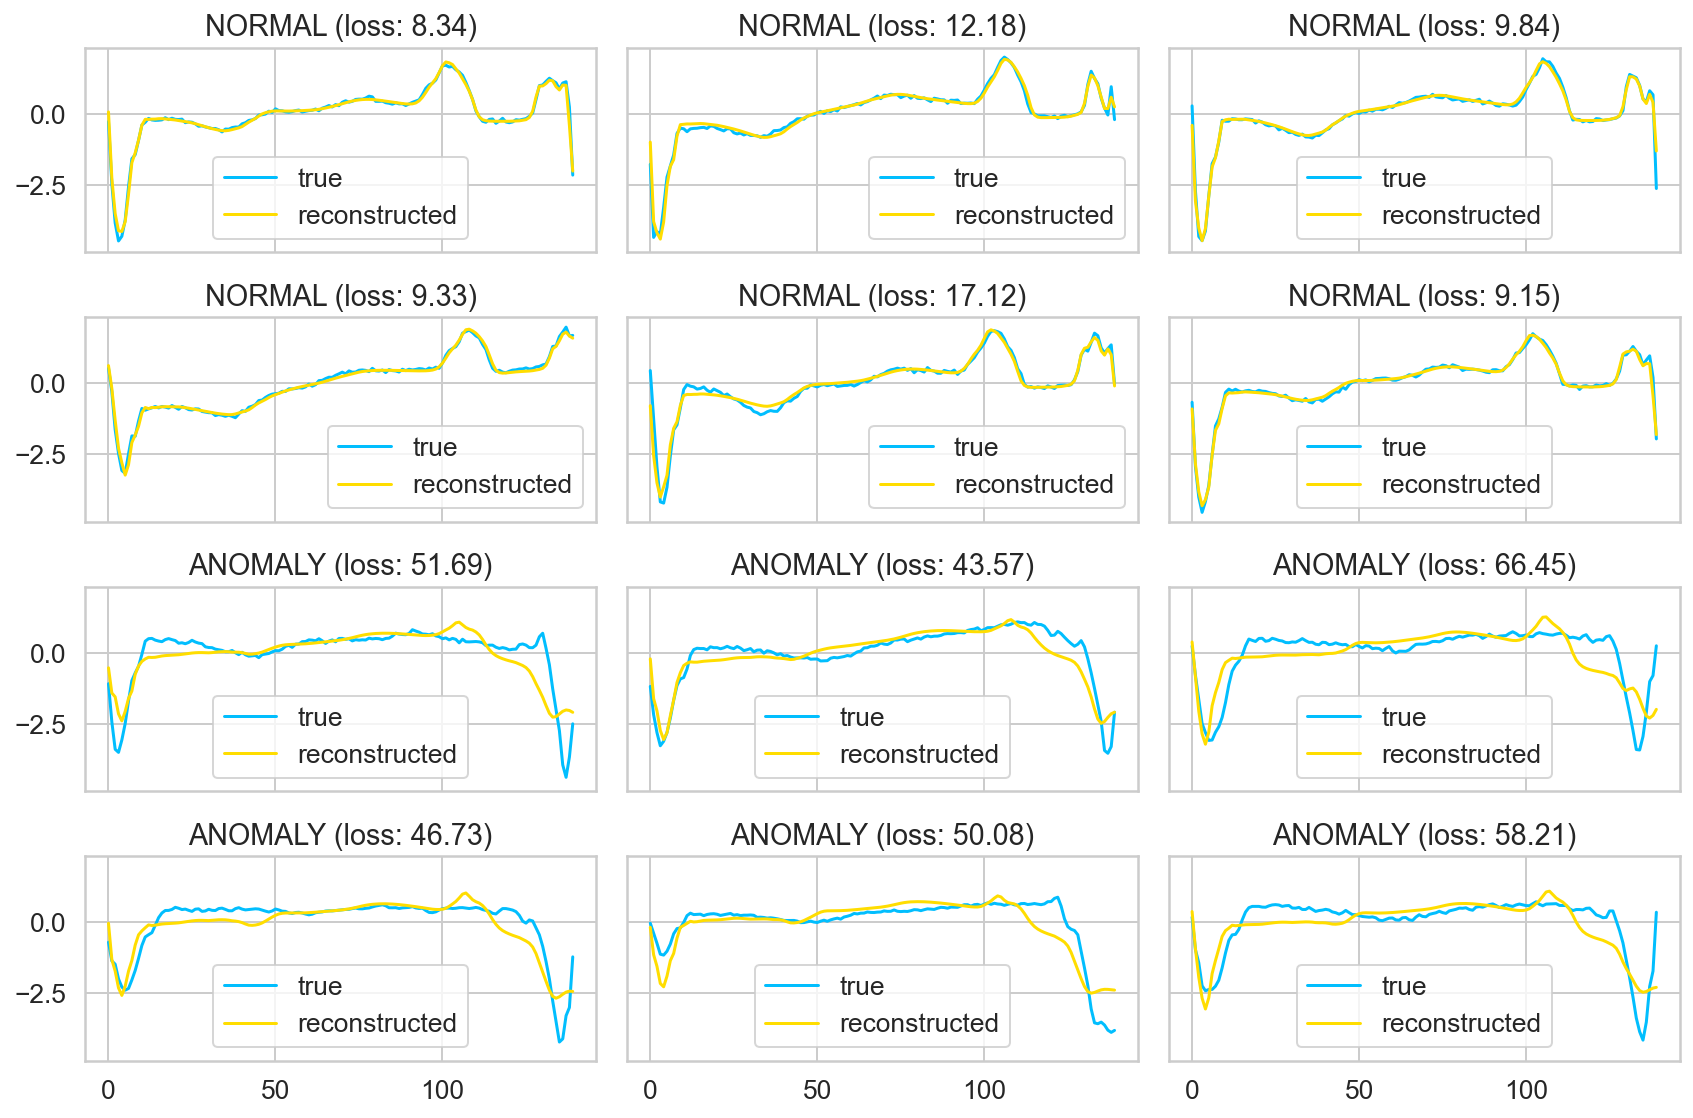

In [245]:
fig, axs = plt.subplots(
  nrows=4,
  ncols=3,
  sharey=True,
  sharex=True,
  #figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:3]):
  plot_prediction(data, model, title='NORMAL', ax=axs[0, i])

for i, data in enumerate(test_normal_dataset[3:6]):
  plot_prediction(data, model, title='NORMAL', ax=axs[1, i])

for i, data in enumerate(test_anomaly_dataset[:3]):
  plot_prediction(data, model, title='ANOMALY', ax=axs[2, i])

for i, data in enumerate(test_anomaly_dataset[3:6]):
  plot_prediction(data, model, title='ANOMALY', ax=axs[3, i])

fig.tight_layout()